In [52]:
ROOT_FOLDER = '/tmp/tf_model'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_elu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_bn_after_relu_v1'
ROOT_FOLDER = '/home/p00lcy01/save/kcnn3_fit_4k'

H5_FILE="../white_h_8192_dm2.h5"
H5_FILE="../whiten4k_dm1.h5"       ## strange

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.4, 1.2, 1.0, 0.8]
TRAIN_A =   [1.2]

SHIFT  = 0.3
NOISE_COPY = 1
SHIFT_COPY = 1

In [53]:
from __future__ import print_function
import os
import time
import h5py as h5
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('agg')             ## Need for CMD
%matplotlib inline

In [57]:
###
###  Load model from json
###
tf.reset_default_graph()
import json

jtext = open("%s/model.json" % ROOT_FOLDER, 'r').read()
####=========  Not work!!
##jobj = json.loads( jtext )
##jobj['config']['layers'][-1]['config']['activation'] = 'sigmoid'
##jtext = json.dumps(jobj)
####=========  

model = keras.models.model_from_json( jtext )

### Modify the last layer
pred  = keras.layers.Dense(1, activation='sigmoid', name='pred')(model.layers[-2].output)
model = keras.Model(model.input, pred)

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', 
                       keras.metrics.Recall(), 
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.AUC(num_thresholds=64, name='roc', curve='ROC'),
                       keras.metrics.AUC(num_thresholds=64, name='pr', curve='PR')
                                          ])
RATE = int(model.input.shape[1])
DIM   = RATE
print("Input rate: ", RATE)

model.summary()
print(model.metrics_names)

Input rate:  4096
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4081, 16)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1020, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1013, 32)          4128      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 253, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 64)           16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 64)

In [58]:
CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, 1.2 )
model.load_weights(CKPT)

test_in = np.random.normal(0,1,RATE)
test_in[RATE//2:RATE//2+100] = 4


pred = model.predict(test_in.reshape(1,RATE,1))
print (pred)


[[1.]]


In [59]:
###
###  Construct TF graph
###

#ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_model'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_relu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_elu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_bn_after_relu_v1'
ROOT_FOLDER = '/home/p00lcy01/save/kcnn3_fit_4k'

act = tf.nn.tanh
act = tf.nn.relu
act = tf.nn.elu

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tf.reset_default_graph()
RATE = 4096
DIM   = RATE
LRATE        = 1e-5   ##-4
#keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
#lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

##########################################
##import GWDA.model
###########################################
F = [16,32,64]
K = [16, 8, 8]
D = [ 1, 1, 1]
S = [ 1, 1, 1]
PO= [ 4, 4, 4]
PS= [ 4, 4, 4]
args0 = { "padding":'valid', "data_format":"channels_last" }
ki  = keras.initializers.TruncatedNormal() ##(seed=2)
ki0 = keras.initializers.Zeros()
input_data = keras.layers.Input(shape=(RATE,1))
################################
a1=keras.layers.Conv1D(F[0], K[0], S[0], dilation_rate=D[0], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(input_data)
a1=keras.layers.MaxPooling1D(PO[0], PS[0], **args0)(a1)
#a1=keras.layers.BatchNormalization(axis=-1)(a1)

a1=keras.layers.Conv1D(F[1], K[1], S[1], dilation_rate=D[1], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[1], PS[1], **args0)(a1)
#a1=keras.layers.BatchNormalization(axis=-1)(a1)

a1=keras.layers.Conv1D(F[2], K[2], S[2], dilation_rate=D[2], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[2], PS[2], **args0)(a1)
#a1=keras.layers.BatchNormalization(axis=-1)(a1)

a1=keras.layers.Flatten()(a1)
a2=keras.layers.Dense(128, kernel_initializer=ki, bias_initializer=ki0, activation=act, name='fc2')(a1)
a2=keras.layers.Dense(64, kernel_initializer=ki, bias_initializer=ki0, activation=act, name='fc1')(a2)
#a2=keras.layers.BatchNormalization(axis=-1)(a2)
################################
a2=keras.layers.Dense(1, activation=tf.nn.sigmoid, name='prediction')(a2)
model = keras.models.Model(input_data, a2)

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy', 
                       keras.metrics.Recall(), 
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.AUC(num_thresholds=64, name='roc', curve='ROC'),
                       keras.metrics.AUC(num_thresholds=64, name='pr', curve='PR')
                                          ])

model.summary()
print(model.metrics_names)
# Compute predictions
#predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
#predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
#loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
#with tf.name_scope('optimizer'):
#    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)

#model.fit(x_train, y_train, batch_size=128 * 2, epochs=2, verbose=1, validation_data=(x_test, y_test))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4081, 16)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1020, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1013, 32)          4128      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 253, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 64)           16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 64)            0     

Sampling rate :  4096
 A= 1.40 : a/s:   0.998   1.000, TP/FP/TN/FN:  5083    24  5060     1 roc/pr:   0.998   0.996 speed:  6030 wf/s
 A= 1.31 : a/s:   0.998   0.999, TP/FP/TN/FN:  5081    18  5066     3 roc/pr:   0.998   0.997 speed:  9306 wf/s
 A= 1.21 : a/s:   0.996   0.997, TP/FP/TN/FN:  5068    23  5061    16 roc/pr:   0.997   0.996 speed: 53020 wf/s
 A= 1.12 : a/s:   0.989   0.980, TP/FP/TN/FN:  4982    11  5073   102 roc/pr:   0.991   0.993 speed: 58525 wf/s
 A= 1.03 : a/s:   0.969   0.941, TP/FP/TN/FN:  4782    18  5066   302 roc/pr:   0.974   0.982 speed: 56051 wf/s
 A= 0.94 : a/s:   0.927   0.857, TP/FP/TN/FN:  4357    18  5066   727 roc/pr:   0.939   0.960 speed: 57336 wf/s
 A= 0.84 : a/s:   0.850   0.705, TP/FP/TN/FN:  3586    24  5060  1498 roc/pr:   0.864   0.907 speed: 59571 wf/s
 A= 0.75 : a/s:   0.753   0.511, TP/FP/TN/FN:  2600    24  5060  2484 roc/pr:   0.767   0.832 speed: 58187 wf/s
 A= 0.66 : a/s:   0.657   0.317, TP/FP/TN/FN:  1612    19  5065  3472 roc/pr:   0.

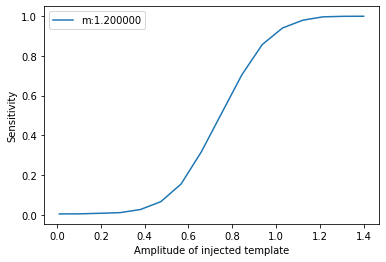

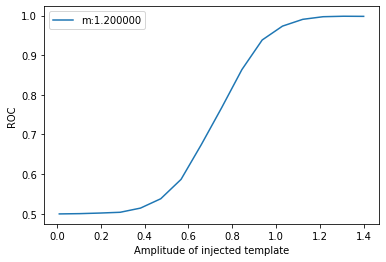

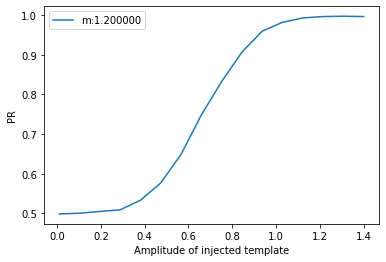

In [43]:
###
###  Testing...
###
import GWDA.loader
GWdata = GWDA.loader.GWInject(H5_FILE)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

BATCH = 4096
TEST_LIST = np.linspace(1.4, 0.01, 16)

with tf.Session() as sess:
    tf.global_variables_initializer().run()

    #fig1 = plt.figure()
    #fig2 = plt.figure()
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    
    for m in TRAIN_A:
        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        #try:
        model.load_weights(CKPT)
        #    print("== Load : ", CKPT)
        #except: 
        #    print("== Found no file ", CKPT)
        #    continue
        
        gout=[]
        for amp in TEST_LIST:

            Xts, Yts  = GWdata.get_test_set(A=amp, nc=NOISE_COPY, sc=NOISE_COPY, shift=SHIFT)
            #X = np.expand_dims(X, axis=-1)  
            #Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=222)
            
            time0 = time.time()

            eout = model.evaluate(Xts, Yts, verbose=0, batch_size=BATCH)
            
            gout.append(eout)
            print(" A= %4.2f : a/s: %7.3f %7.3f, TP/FP/TN/FN: %5d %5d %5d %5d roc/pr: %7.3f %7.3f speed: %5d wf/s" 
                  % (amp, eout[1], eout[2], eout[3], eout[4], eout[5], eout[6], eout[7], eout[8], len(Yts)/(time.time()-time0) ) )

            ###
            #yprob = model.predict(Xts, verbose=0, batch_size=512)
            #ff = roc_curve(Yts, yprob)
            #print(ff)
            #print(Yts)
        
        gout = np.array(gout)
        ax1.plot(TEST_LIST, gout[:,2], label="m:%f"%m)
        ax2.plot(TEST_LIST, gout[:,7], label="m:%f"%m)
        ax3.plot(TEST_LIST, gout[:,8], label="m:%f"%m)

        with open("%s/his_test.log" % (ROOT_FOLDER), 'a') as f:
            f.write("### A=%4.2f\n" % (amp)  )
            for i in range( len(TEST_LIST) ):
                f.write("%5f %s\n" % ( TEST_LIST[i], " ".join(str(item) for item in gout[i,:])) )
            f.write("\n\n")

    
    FIGNAME = "%s/infer.png" % (ROOT_FOLDER)
    ax1.set_xlabel("Amplitude of injected template")
    ax1.set_ylabel("Sensitivity")
    ax1.legend()
    fig1.savefig(FIGNAME)
    FIGNAME_ROC = "%s/infer_roc.png" % (ROOT_FOLDER)
    ax2.set_xlabel("Amplitude of injected template")
    ax2.set_ylabel("ROC")
    ax2.legend()
    fig2.savefig(FIGNAME_ROC)
    FIGNAME_PR = "%s/infer_pr.png" % (ROOT_FOLDER)
    ax3.set_xlabel("Amplitude of injected template")
    ax3.set_ylabel("PR")
    ax3.legend()
    fig3.savefig(FIGNAME_PR)

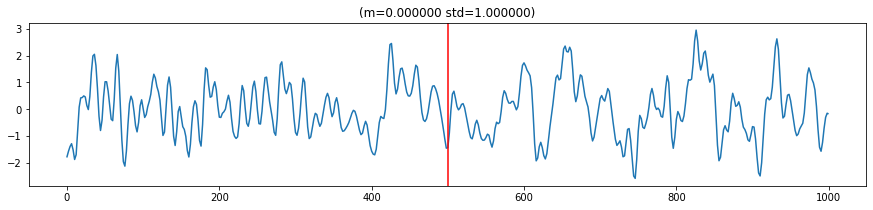

Input shape: (1000,)
Load :  /home/p00lcy01/save/kcnn3_fit_4k/model_1.20.h5


ValueError: negative dimensions are not allowed

In [79]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

SKIP = 5*RATE  ##4*RATE   ## to remove the FFT gibbs effect
#data = np.load("../real8k/GW151226_L1_w.npy")[SKIP:-SKIP]   ## too many FAR
data = np.load("../real8k/GW151226_H1_w.npy")[SKIP:-SKIP]   ## too many FAR
#data = np.load("../real8k/LVT151012_H1_w.npy")[SKIP:-SKIP]  ## too many FAR
#data = np.load("../real8k/GW170104_L1_w.npy")[SKIP:-SKIP]  ## too many FAR
#data = np.load("../real8k/LVT151012_L1_w.npy")[3*SKIP:-3*SKIP]
#data = np.load("../real8k/GW150914_H1_w.npy")[SKIP:-SKIP]   # perfect for BN
#data = np.load("../real8k/GW150914_L1_w.npy")[SKIP:-SKIP]    ## so so
#data = np.load("../real8k/GW151226_H1_bp.npy")[5*SKIP:-5*SKIP]
data = np.load("../real8k/GW151226_H1_bp.npy")[1000:2000]

mean = np.mean(data)
std  = np.std(data)
data = (data-mean)/std

plt.figure(**wopt)
plt.plot(data)
plt.axvline(0.5*len(data), color='r')
plt.title("(m=%f std=%f)" % (np.mean(data), np.std(data)) )
plt.show()

print("Input shape:", data.shape)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 8   ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 512
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE, 1])

            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:,0] = data[s:s+RATE]

            p_ = model.predict(xbatch, verbose=0)
            #p_ = keras.backend.sigmoid( p_.flatten() )

            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        #plt.plot(prob[11000:-11000])
        plt.plot(prob)


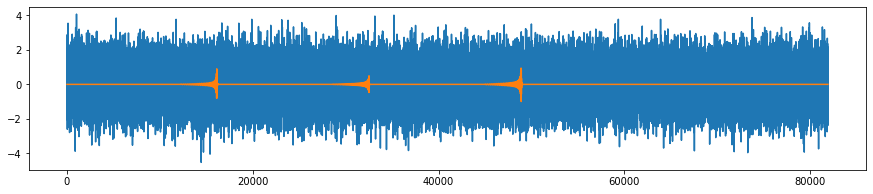

Load :  /home/p00lcy01/save/kcnn3_fit_4k/model_1.20.h5


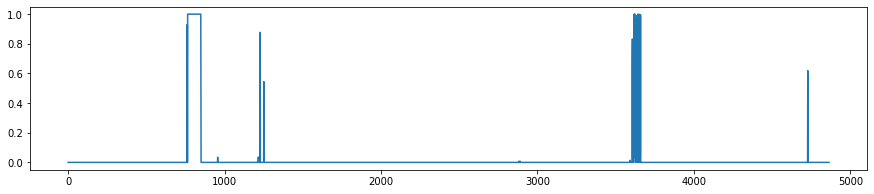

In [48]:
###
###  Testing fake data...
###
import GWDA.loader
H5_FILE="../white_h_8192_dm2.h5"
H5_FILE="../whiten8k_dm2.h5"
H5_FILE="../whiten4k_dm1.h5"

wopt = {"figsize": (15,3) }
TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.2]

def gen3():
    A=[0.9,0.5,1]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['test_hc'][110]
    inj2 = tmp.f['test_hc'][70]
    inj3 = tmp.f['test_hc'][90]

    data  = np.random.normal(0,1,RATE*20)
    data[3*RATE:4*RATE] += A[0]*inj1
    data[7*RATE:8*RATE] += A[1]*inj2
    data[11*RATE:12*RATE] += A[2]*inj3
    exact = np.zeros(RATE*20)
    exact[3*RATE:4*RATE] += A[0]*inj1
    exact[7*RATE:8*RATE] += A[1]*inj2
    exact[11*RATE:12*RATE] += A[2]*inj3
    return exact, data



def gen1():
    A=[0.9]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['test_hc'][120]

    data  = np.random.normal(0,1,RATE*3)
    data[RATE:2*RATE] += A[0]*inj1
    exact = np.zeros(RATE*3)
    exact[RATE:2*RATE] += A[0]*inj1
    return exact, data

exact, data = gen3()

plt.figure(**wopt)
plt.plot(data)
plt.plot(exact)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #saver = tf.train.Saver(max_to_keep=50)

    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 16    ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 256
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE, 1])
            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:,0] = data[s:s+RATE]
            p_ = model.predict(xbatch, verbose=0)
            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        plt.plot(prob.flatten())



In [81]:
def visualize_conv_layer(layer_name):
  layer_output=model.get_layer(layer_name).output
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x_train[2].reshape(1,28,28,1))
  
  row_size=4
  col_size=8
  
  img_index=0
 
  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))
 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
 
      img_index=img_index+1
    
#visualize_conv_layer('conv1')
